<a href="https://colab.research.google.com/github/datrends/ML-modelo-de-clasificacion/blob/main/Modelo%20para%20predecir%20siniestros.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DEMO: Machine Learning para predecir siniestros

# Librerías útiles

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

import seaborn as sns
import scipy as sp
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB

# Carga de Datos:

In [2]:
# Cargo el conjunto de datos de entrenamiento
train = pd.read_csv('https://raw.githubusercontent.com/datrends/ML-modelo-de-clasificacion/main/data/train.csv')

# Cargo el conjunto de datos de prueba
test = pd.read_csv('https://raw.githubusercontent.com/datrends/ML-modelo-de-clasificacion/main/data/test.csv')

# Concateno los dos conjuntos para realizar una exploración completa de los datos
data = pd.concat([train,test], sort=False)

# Muestro las primeras filas que componen el conjunto de datos
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
# Muestro las últimas filas que componen el conjunto de datos
data.tail()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
413,1305,NaN,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,NaN,S
414,1306,NaN,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,C
415,1307,NaN,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S
416,1308,NaN,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.0500,NaN,S
417,1309,NaN,3,"Peter, Master. Michael J",male,NaN,1,1,2668,22.3583,NaN,C


# Análisis Exploratorio de Datos:

In [4]:
# Listo las columnas y valido sus tipos de datos para determinar cuales variables son cualitativas y cuales cuantitativas
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 0 to 417
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  1309 non-null   int64  
 1   Survived     891 non-null    float64
 2   Pclass       1309 non-null   int64  
 3   Name         1309 non-null   object 
 4   Sex          1309 non-null   object 
 5   Age          1046 non-null   float64
 6   SibSp        1309 non-null   int64  
 7   Parch        1309 non-null   int64  
 8   Ticket       1309 non-null   object 
 9   Fare         1308 non-null   float64
 10  Cabin        295 non-null    object 
 11  Embarked     1307 non-null   object 
dtypes: float64(3), int64(4), object(5)
memory usage: 132.9+ KB


In [5]:
# Hago un resumen estadístico muy básico de los datos
data.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,1309.000000,891.000000,1309.000000,1046.000000,1309.000000,1309.000000,1308.000000
mean,655.000000,0.383838,2.294882,29.881138,0.498854,0.385027,33.295479
std,378.020061,0.486592,0.837836,14.413493,1.041658,0.865560,51.758668
min,1.000000,0.000000,1.000000,0.170000,0.000000,0.000000,0.000000
25%,328.000000,0.000000,2.000000,21.000000,0.000000,0.000000,7.895800
50%,655.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,982.000000,1.000000,3.000000,39.000000,1.000000,0.000000,31.275000
max,1309.000000,1.000000,3.000000,80.000000,8.000000,9.000000,512.329200


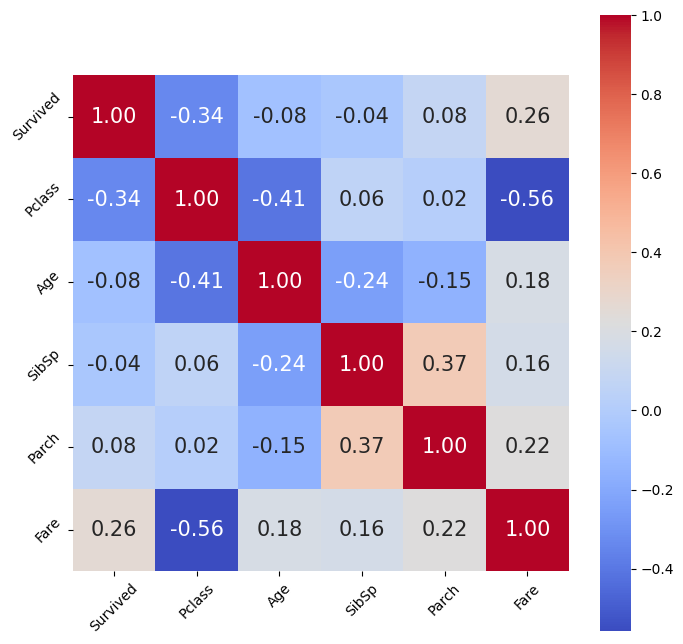

In [6]:
# Construyo una matrix de correlación (usando el coeficiente de Pearson)
# para determinar que variables cuantitativas tienen una mayor correlación lineal.
# cfcte < 0 ... representa una correlación inversa, es decir, a mayor valor de la variable A le corresponde un menor valor de la variable B
# cfte > 0 ... representa una correlación lineal, es decir, a mayor valor de la variable A le corresponde un mayor valor de la variable B
features_numeric = ['Survived', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare']
corr_0 = data[features_numeric].corr()
plt.figure(figsize=(8,8))
ax=sns.heatmap(corr_0, cbar = True,  square = True, annot=True, fmt= '.2f',annot_kws={'size': 15},
           cmap= 'coolwarm')
plt.xticks(rotation = 45)
plt.yticks(rotation = 45)
plt.show()

# Visualización de variables

## Survived

Text(0.5, 1.0, 'Supervivencia')

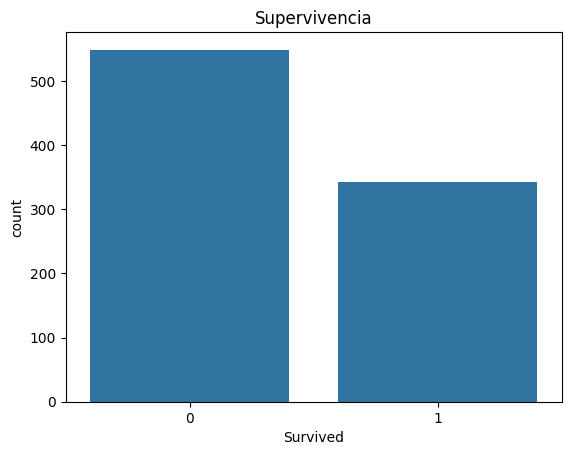

In [7]:
# Histograma de la variable objetivo --> Supervivencia (Survived)
sns.countplot(data=train, x='Survived')
plt.title('Supervivencia')

In [8]:
# Porcentaje de supervivencia
print('Porcentaje de supervivencia:',(train.Survived.sum()/train.Survived.count())*100)

Porcentaje de supervivencia: 38.38383838383838


## Pclass

Text(0.5, 1.0, 'Supervivencia por Clase')

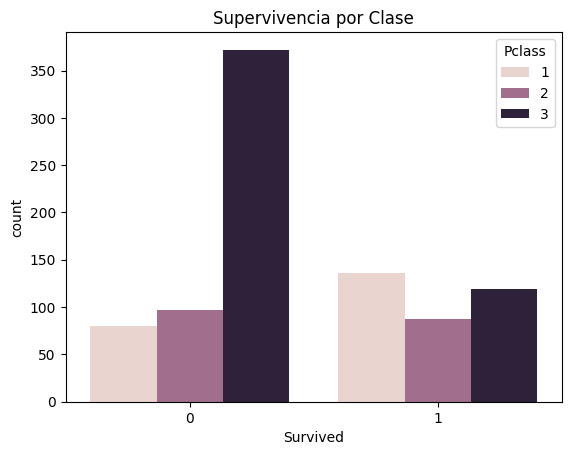

In [9]:
# Histograma de la supervivencia por tipo de clase
sns.countplot(data=train, x='Survived', hue='Pclass')
plt.title('Supervivencia por Clase')

In [10]:
# Porcentaje de supervivencia por tipos de clase
print('Porcentaje de supervivencia Clase 1:', (train[train.Pclass==1].Survived.sum()/train[train.Pclass==1].Survived.count())*100)
print('Porcentaje de supervivencia Clase 2:', (train[train.Pclass==2].Survived.sum()/train[train.Pclass==2].Survived.count())*100)
print('Porcentaje de supervivencia Clase 3:', (train[train.Pclass==3].Survived.sum()/train[train.Pclass==3].Survived.count())*100)

Porcentaje de supervivencia Clase 1: 62.96296296296296
Porcentaje de supervivencia Clase 2: 47.28260869565217
Porcentaje de supervivencia Clase 3: 24.236252545824847


## Sex

Text(0.5, 1.0, 'Supervivencia por Sex')

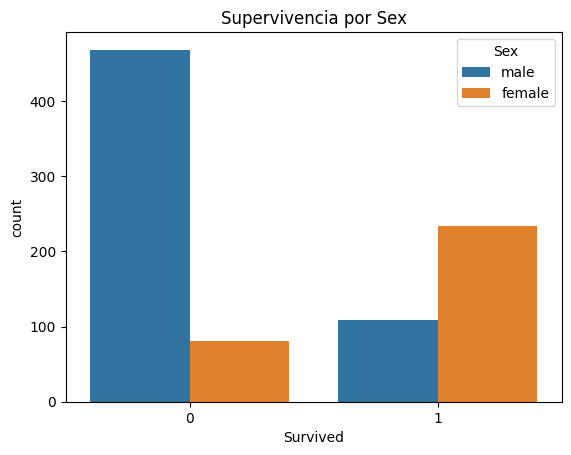

In [11]:
sns.countplot(data=train, x='Survived', hue='Sex')
plt.title('Supervivencia por Sex')

In [12]:
#Porcentaje de supervivencia por Sexo
print('Porcentaje de supervivencia Mujeres:', (train[train.Sex=='female'].Survived.sum()/train[train.Sex=='female'].Survived.count())*100)
print('Porcentaje de supervivencia Hombres:', (train[train.Sex=='male'].Survived.sum()/train[train.Sex=='male'].Survived.count())*100)

Porcentaje de supervivencia Mujeres: 74.20382165605095
Porcentaje de supervivencia Hombres: 18.890814558058924


## Age

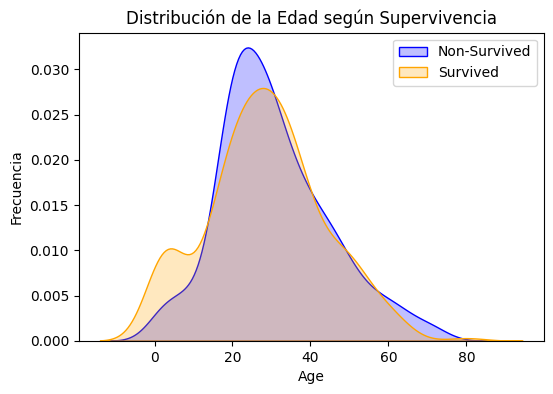

In [13]:
# Distribución la supervivencia según la edad
plt.subplots(figsize=(6,4))

ax=sns.kdeplot(train.loc[(train['Survived'] == 0),'Age'],color='blue',fill=True, label='Non-Survived')
ax=sns.kdeplot(train.loc[(train['Survived'] == 1),'Age'],color='orange',fill=True, label='Survived')
plt.title('Distribución de la Edad según Supervivencia')
plt.ylabel('Frecuencia')
plt.xlabel('Age')
plt.legend(loc="upper right")
plt.show()

In [14]:
# Agrego una nueva variable a los datos_ creando rangos para las edades.
bins = [ 0, 5, 12, 18, 25, 35, 60, np.inf]
labels = ['0-5', '6-12', '13-18', '19-25', '26-35', '36-60', '61-80']
train['AgeGroup'] = pd.cut(train["Age"], bins, labels = labels)

Text(0.5, 1.0, 'Supervivencia por Rango de Edad')

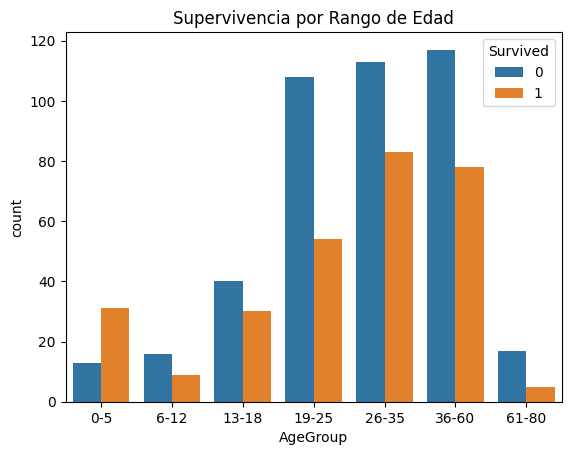

In [15]:
# Distribución de la supervivencia por rango de edad
sns.countplot(data=train, x='AgeGroup', hue='Survived')
plt.title('Supervivencia por Rango de Edad')

In [16]:
# Porcentaje de supervivencia por Rango de Edad
print('Porcentaje de supervivencia   0-5 años:', (train[train.AgeGroup=='0-5'].Survived.sum()/train[train.AgeGroup=='0-5'].Survived.count())*100)
print('Porcentaje de supervivencia  5-12 años:', (train[train.AgeGroup=='6-12'].Survived.sum()/train[train.AgeGroup=='6-12'].Survived.count())*100)
print('Porcentaje de supervivencia 12-18 años:', (train[train.AgeGroup=='13-18'].Survived.sum()/train[train.AgeGroup=='13-18'].Survived.count())*100)
print('Porcentaje de supervivencia 18-25 años:', (train[train.AgeGroup=='19-25'].Survived.sum()/train[train.AgeGroup=='19-25'].Survived.count())*100)
print('Porcentaje de supervivencia 25-35 años:', (train[train.AgeGroup=='26-35'].Survived.sum()/train[train.AgeGroup=='26-35'].Survived.count())*100)
print('Porcentaje de supervivencia 35-60 años:', (train[train.AgeGroup=='36-60'].Survived.sum()/train[train.AgeGroup=='36-60'].Survived.count())*100)
print('Porcentaje de supervivencia 60-80 años:', (train[train.AgeGroup=='61-80'].Survived.sum()/train[train.AgeGroup=='61-80'].Survived.count())*100)

Porcentaje de supervivencia   0-5 años: 70.45454545454545
Porcentaje de supervivencia  5-12 años: 36.0
Porcentaje de supervivencia 12-18 años: 42.857142857142854
Porcentaje de supervivencia 18-25 años: 33.33333333333333
Porcentaje de supervivencia 25-35 años: 42.3469387755102
Porcentaje de supervivencia 35-60 años: 40.0
Porcentaje de supervivencia 60-80 años: 22.727272727272727


## SibSp & Parch

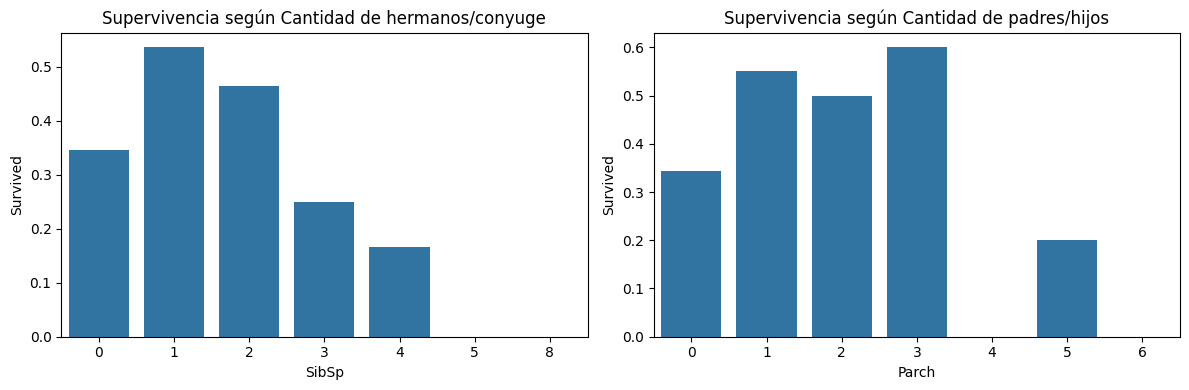

In [17]:
fig, (ax1,ax2)= plt.subplots(1,2,figsize=(12,4))

ax1=sns.barplot(x="SibSp", y="Survived", data=train, errorbar=None, ax=  ax1)
ax1.set_title('Supervivencia según Cantidad de hermanos/conyuge')

ax2=sns.barplot(x="Parch", y="Survived", data=train, errorbar=None, ax=  ax2)
ax2.set_title('Supervivencia según Cantidad de padres/hijos')

plt.tight_layout()
plt.show()

## Fare

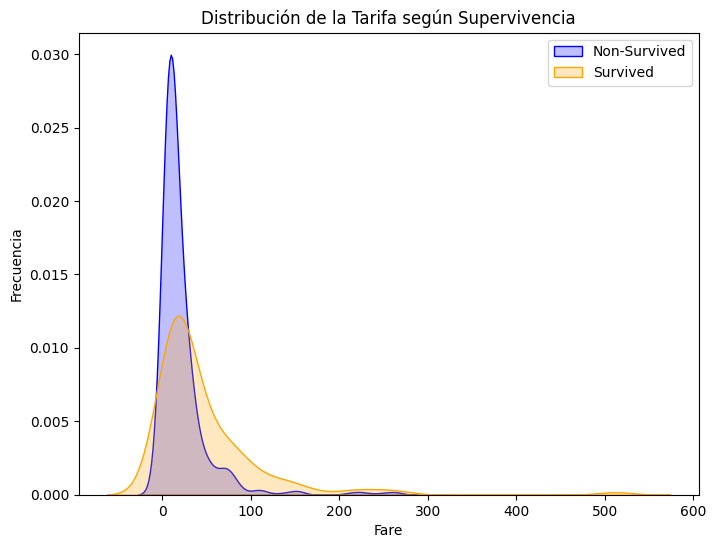

In [18]:
# Distribución de la supervivencia según la tarifa del ticket
# Nota: Menor dispersión de los datos.
plt.subplots(figsize=(8,6))

ax=sns.kdeplot(train.loc[(train['Survived'] == 0),'Fare'],color='blue',fill=True, label='Non-Survived')
ax=sns.kdeplot(train.loc[(train['Survived'] == 1),'Fare'],color='orange',fill=True, label='Survived')
plt.title('Distribución de la Tarifa según Supervivencia')
plt.ylabel('Frecuencia')
plt.xlabel('Fare')
plt.legend(loc="upper right")
plt.show()

Text(0.5, 1.0, 'Supervivencia según tarifa y clase')

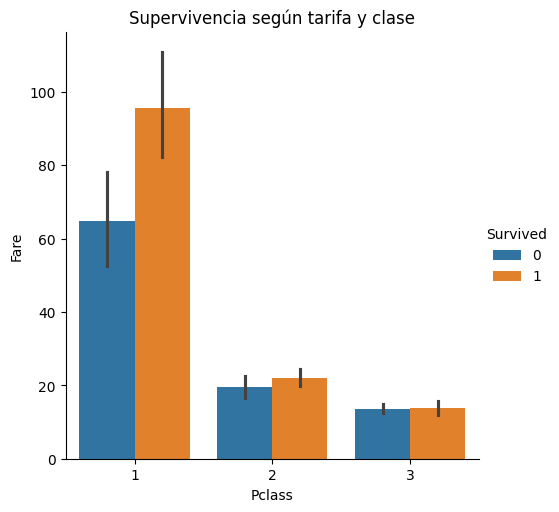

In [19]:
# Supervivencia según tarifa y clase (gráfico bi-variado)
sns.catplot(x="Pclass", y="Fare",hue='Survived', kind="bar", data=train)
plt.title('Supervivencia según tarifa y clase')

## Embarked

Text(0.5, 1.0, 'Supervivencia según Puerto de Embarque')

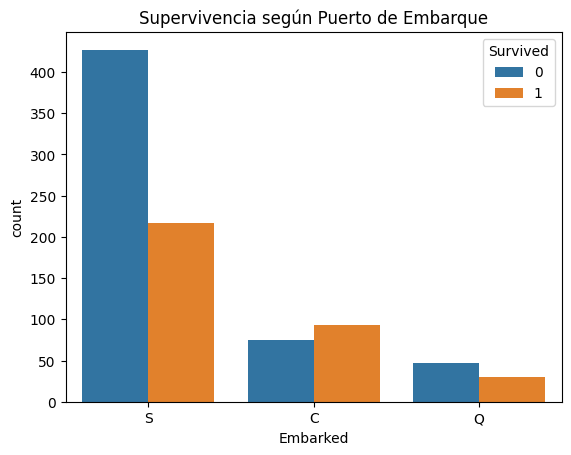

In [20]:
sns.countplot(data=train, x='Embarked', hue='Survived')
plt.title('Supervivencia según Puerto de Embarque')

In [21]:
print('Porcentaje de supervivencia puerto Southampton:', (train[train.Embarked=='S'].Survived.sum()/train[train.Embarked=='S'].Survived.count())*100)
print('Porcentaje de supervivencia puerto Cherburgo:  ', (train[train.Embarked=='C'].Survived.sum()/train[train.Embarked=='C'].Survived.count())*100)
print('Porcentaje de supervivencia puerto Queenstown: ', (train[train.Embarked=='Q'].Survived.sum()/train[train.Embarked=='Q'].Survived.count())*100)

Porcentaje de supervivencia puerto Southampton: 33.69565217391305
Porcentaje de supervivencia puerto Cherburgo:   55.35714285714286
Porcentaje de supervivencia puerto Queenstown:  38.961038961038966


### Observaciones:
   - La clase con mayor supervivencia fue Pclass=1, y con menor supervivencia Pclass=3.
   - La tasa de supervivencia de las mujeres fue mayor a la de hombres.
   - Los infantes cuya edad sea menor o igual a 5 años tienen mayores probabilidades de sobrevivir
   - El puerto de embarque no parece tener relación directa con la supervivencia.
   - Los pasajeros que pagaban tarifas más altas, tenían mayor probabilidad de supervivencia.
   - Los pasajeros con familia no tan numerosa tienen mayores probabilidades de sobrevivir

# Corrección a los datos de entrenamiento

Teniendo en cuenta la anterior exploración en los datos, listo las columnas de las que se compone el conjunto de entrenamiento:

In [22]:
data.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

## Datos incompletos

Realizo una exploración sobre los atributos del conjuto para determinar cuales de ellos contienen demasiados valores nulos. Sólo conservaremos aquellos atributos cuyos datos no excedan el 30% de las filas con valores vacios/nulos.

In [23]:
print('% Porcentaje de valores nulos...')
nulls = data.isna().sum()
print((nulls/data['PassengerId'].count())*100)

% Porcentaje de valores nulos...
PassengerId     0.000000
Survived       31.932773
Pclass          0.000000
Name            0.000000
Sex             0.000000
Age            20.091673
SibSp           0.000000
Parch           0.000000
Ticket          0.000000
Fare            0.076394
Cabin          77.463713
Embarked        0.152788
dtype: float64


Conservaré la variable 'Survived' dado que sus valores faltantes corresponden a filas del conjunto de prueba y por tanto se requeriran para las instancias a predecir.

Se elimina la variable 'Cabin' ya que posee un porcentaje elevado de valores faltantes y supera el criterio de calidad establecido para el conjunto de entrenamiento.

Intentar una corrección en los datos agregaría un sesgo a los datos.

In [24]:
#Elimino la variable Cabin por la cantidad de valores faltantes
data.drop(columns='Cabin', inplace=True, axis=1 )

data.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Embarked'],
      dtype='object')

Se realiza una corrección a los valores nulos de las variables Age y Fare con la media, y los de la variables Embarked con la moda. Se establece este criterio de corrección para no afectar la distribución de los datos.

In [25]:
#Imputo los datos faltantes en Age y Fare con la media, y en Embarked con la moda
data['Age'].fillna((data['Age'].mean()), inplace=True)
data['Fare'].fillna((data['Fare'].mean()), inplace=True)
data['Embarked'].fillna(data['Embarked'].mode()[0],inplace=True)

In [26]:
data.isna().sum()

PassengerId      0
Survived       418
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Ticket           0
Fare             0
Embarked         0
dtype: int64

## Atributos no relevantes

Eliminaremos del conjunto de entrenamiento las siguientes variables que no aportan en la predicción por su naturaleza y pertinencia al caso predictivo y porque además representan valores únicos a nivel de fila. Conservamos sólo la variable 'PassengerId' que será la llave de identificación de la predicción relacionada a un pasajero:
   * 'Ticket'

In [27]:
#Elimino la variable ticket porque su naturaleza de valor único no aporta en el ejercicio de predicción
data.drop(columns=['Ticket'], inplace=True, axis=1 )

data.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Fare', 'Embarked'],
      dtype='object')

## Generación de nuevas variables

La variable 'Name' aunque no aporta un valor único para cada instancia, sin embargo, el título asociado a la persona nos puede proporcionar información relevante. Por tanto, la covertiremos en una variable categórica.

In [28]:
data['Title'] = data['Name'].str.split(', ').str[1].str.split('.').str[0]
data.Title.value_counts()

Mr              757
Miss            260
Mrs             197
Master           61
Rev               8
Dr                8
Col               4
Mlle              2
Major             2
Ms                2
Lady              1
Sir               1
Mme               1
Don               1
Capt              1
the Countess      1
Jonkheer          1
Dona              1
Name: Title, dtype: int64

In [29]:
#Englobamos los títulos encontrados en sólo 4 principales
dic={'Ms': 'Miss','Mlle': 'Miss',
         'Mme': 'Mrs','Dona': 'Mrs','the Countess': 'Mrs','Lady': 'Mrs',
             'Rev': 'Mr','Jonkheer': 'Mr','Dr': 'Mr','Capt': 'Mr','Don': 'Mr','Col': 'Mr','Major': 'Mr','Sir': 'Mr'}
data.replace({'Title': dic}, inplace=True)
data.Title.value_counts()

Mr        783
Miss      264
Mrs       201
Master     61
Name: Title, dtype: int64

Podemos agrupar por rango de edades

In [30]:
bins = [ 0, 5, 12, 18, 25, 35, 60, np.inf]
labels = ['0-5', '6-12', '13-18', '19-25', '26-35', '36-60', '61-80']
data['AgeGroup'] = pd.cut(data["Age"], bins, labels = labels)

Con las variables Sibpb y Parch podemos calcular el tamaño de la familia:

In [31]:
data['FamilySize']=data['SibSp'] + data['Parch'] + 1

In [32]:
data.drop(columns=['Name'], inplace=True, axis=1)
data.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title,AgeGroup,FamilySize
0,1,0.0,3,male,22.0,1,0,7.2500,S,Mr,19-25,2
1,2,1.0,1,female,38.0,1,0,71.2833,C,Mrs,36-60,2
2,3,1.0,3,female,26.0,0,0,7.9250,S,Miss,26-35,1
3,4,1.0,1,female,35.0,1,0,53.1000,S,Mrs,26-35,2
4,5,0.0,3,male,35.0,0,0,8.0500,S,Mr,26-35,1


## Encoding

In [33]:
le = LabelEncoder()
data['Sex'] = le.fit_transform(data['Sex'])
data['Embarked'] = le.fit_transform(data['Embarked'])
data['Title'] = le.fit_transform(data['Title'])
data['AgeGroup']= le.fit_transform(data['AgeGroup'])


In [34]:
data.isna().sum()

PassengerId      0
Survived       418
Pclass           0
Sex              0
Age              0
SibSp            0
Parch            0
Fare             0
Embarked         0
Title            0
AgeGroup         0
FamilySize       0
dtype: int64

In [35]:
data

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title,AgeGroup,FamilySize
0,1,0.0,3,1,22.000000,1,0,7.2500,2,2,2,2
1,2,1.0,1,0,38.000000,1,0,71.2833,0,3,4,2
2,3,1.0,3,0,26.000000,0,0,7.9250,2,1,3,1
3,4,1.0,1,0,35.000000,1,0,53.1000,2,3,3,2
4,5,0.0,3,1,35.000000,0,0,8.0500,2,2,3,1
...,...,...,...,...,...,...,...,...,...,...,...,...
413,1305,NaN,3,1,29.881138,0,0,8.0500,2,2,3,1
414,1306,NaN,1,0,39.000000,0,0,108.9000,0,3,4,1
415,1307,NaN,3,1,38.500000,0,0,7.2500,2,2,4,1
416,1308,NaN,3,1,29.881138,0,0,8.0500,2,2,3,1


## Entrenamiento de modelos

Separamos de nuevo los conjuntos de entrenamiento y testeo

In [36]:
ds_train = data.iloc[:891]
ds_test = data.iloc[891:1310]

In [37]:
# Todas las variables --> features = ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked', 'Title', 'AgeGroup', 'FamilySize']

# Variables predictoras seleccionadas a partir de la exploración de datos.
features = ['Pclass', 'Sex', 'Title', 'AgeGroup', 'FamilySize']

# Elaboración del subconjunto de train y test para evaluar la precisión de los modelos
X = ds_train[features]
y = ds_train['Survived']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, stratify = y, random_state=42)

### Árbol de decisión

In [38]:
tree=DecisionTreeClassifier(random_state=42)
tree.fit(X_train, y_train)
y_pred = tree.predict(X_test)
print(accuracy_score(y_test,y_pred))

0.75


### Random Forest

In [39]:
rf = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=1)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
print(accuracy_score(y_test,y_pred))

0.832089552238806


### Vecinos más cercanos

In [40]:
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
print(accuracy_score(y_test,y_pred))

0.7985074626865671


El modelo con los mejores resultado es el RandomForest, por tanto calcularemos las predicciones con éste modelo:

In [41]:
predicciones = rf.predict(ds_test[features])

#probabilidades = rf.predict_proba(ds_test[features])
#output = pd.DataFrame({'PassengerId': ds_test.PassengerId, 'Prediccion': predicciones, 'Probabilidad Supervivencia': probabilidades})

output = pd.DataFrame({'PassengerId': ds_test.PassengerId, 'Prediccion': predicciones})
output.to_csv('resultado_prediccion.csv', index=False)
print("Your submission was successfully saved!")

Your submission was successfully saved!
